Employee Feedback Sentiment Analysis — Summary Report

1. Detailed Sentiment Breakdown Per Review

Review Index  Compound Score  Positive  Negative  Neutral
------------------------------------------------------------
0             0.000           0.0       0.0       1.0    
1             0.000           0.0       0.0       1.0    
2             0.000           0.0       0.0       1.0    
3             0.000           0.0       0.0       1.0    
4             0.400           1.0       0.0       0.0    
...
65638         0.500           1.0       0.0       0.0    

Total number of reviews analyzed: 65639

2. Overall Company Sentiment Summary

Company         Compound Score  Positive Ratio  Negative Ratio  Neutral Ratio   Total Reviews  
------------------------------------------------------------------------------------------
Sopra Steria    0.265           47.5%           6.0%            46.5%           65639          

Notes:
- Compound Score ranges from -1 (very negative) to +1 (very

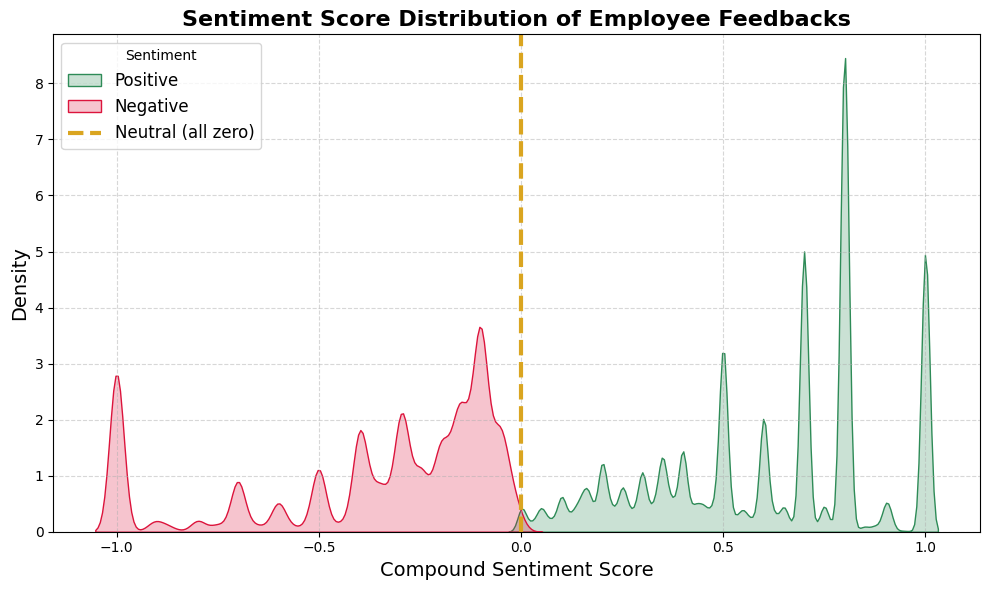

In [4]:

import pandas as pd
import numpy as np
from textblob import TextBlob


df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')


compound_list = []
positive_list = []
negative_list = []
neutral_list = []


for sentence in df["summary"]:
    blob = TextBlob(str(sentence))  # Convert to string in case of NaNs
    polarity = blob.sentiment.polarity

 
    if polarity > 0:
        sentiment = 'positive'
    elif polarity < 0:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

   
    compound_list.append(polarity)
    positive_list.append(1 if sentiment == 'positive' else 0)
    negative_list.append(1 if sentiment == 'negative' else 0)
    neutral_list.append(1 if sentiment == 'neutral' else 0)


df_reviews = pd.DataFrame({
    "Compound": compound_list,
    "Positive": positive_list,
    "Negative": negative_list,
    "Neutral": neutral_list
})


df_company = pd.DataFrame([{
    "Company": "Sopra Steria",
    "Compound": np.mean(compound_list),
    "Positive": np.mean(positive_list),
    "Negative": np.mean(negative_list),
    "Neutral": np.mean(neutral_list),
    "Review Count": len(compound_list)
}])

df_company.set_index("Company", inplace=True)

def print_sentiment_report(df_reviews, df_company):
    print("Employee Feedback Sentiment Analysis — Summary Report\n")
    
   
    print("1. Detailed Sentiment Breakdown Per Review\n")
    print(f"{'Review Index':<13} {'Compound Score':<15} {'Positive':<9} {'Negative':<9} {'Neutral':<7}")
    print("-" * 60)
   
    for idx, row in df_reviews.head(5).iterrows():
        print(f"{idx:<13} {row['Compound']:<15.3f} {row['Positive']:<9} {row['Negative']:<9} {row['Neutral']:<7}")
    
    print("...")
    
 
    last_idx = df_reviews.index[-1]
    last_row = df_reviews.iloc[-1]
    print(f"{last_idx:<13} {last_row['Compound']:<15.3f} {last_row['Positive']:<9} {last_row['Negative']:<9} {last_row['Neutral']:<7}")
    print(f"\nTotal number of reviews analyzed: {len(df_reviews)}\n")
    
   
    print("2. Overall Company Sentiment Summary\n")
    print(f"{'Company':<15} {'Compound Score':<15} {'Positive Ratio':<15} {'Negative Ratio':<15} {'Neutral Ratio':<15} {'Total Reviews':<15}")
    print("-" * 90)
    
    for company, row in df_company.iterrows():
        pos_pct = f"{row['Positive']*100:.1f}%"
        neg_pct = f"{row['Negative']*100:.1f}%"
        neu_pct = f"{row['Neutral']*100:.1f}%"
        print(f"{company:<15} {row['Compound']:<15.3f} {pos_pct:<15} {neg_pct:<15} {neu_pct:<15} {int(row['Review Count']):<15}")
    
    print("\nNotes:")
    print("- Compound Score ranges from -1 (very negative) to +1 (very positive).")
    print("- Positive / Negative / Neutral Ratios represent proportion of reviews in each sentiment category.")
    print("- The data shows a generally positive overall sentiment with a large portion of neutral reviews.\n")
    
    print("Summary:")
    print("The sentiment analysis on employee feedback highlights a predominantly positive and neutral tone in the company's reviews, with only a small fraction expressing negative sentiment. This indicates a generally healthy employee sentiment that can be further explored for actionable insights.")

print_sentiment_report(df_reviews, df_company)



import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,6))


sns.kdeplot(df_reviews.loc[df_reviews['Positive'] == 1, 'Compound'], 
            label='Positive', fill=True, color='seagreen', bw_adjust=0.3)


sns.kdeplot(df_reviews.loc[df_reviews['Negative'] == 1, 'Compound'], 
            label='Negative', fill=True, color='crimson', bw_adjust=0.3)


neutral_scores = df_reviews.loc[df_reviews['Neutral'] == 1, 'Compound']

if neutral_scores.nunique() == 1:
   
    plt.axvline(x=neutral_scores.iloc[0], color='goldenrod', linestyle='--', linewidth=3, label='Neutral (all zero)')
else:
    sns.kdeplot(neutral_scores, label='Neutral', fill=True, color='goldenrod', bw_adjust=0.3)

plt.title("Sentiment Score Distribution of Employee Feedbacks", fontsize=16, fontweight='bold')
plt.xlabel("Compound Sentiment Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.legend(title='Sentiment', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

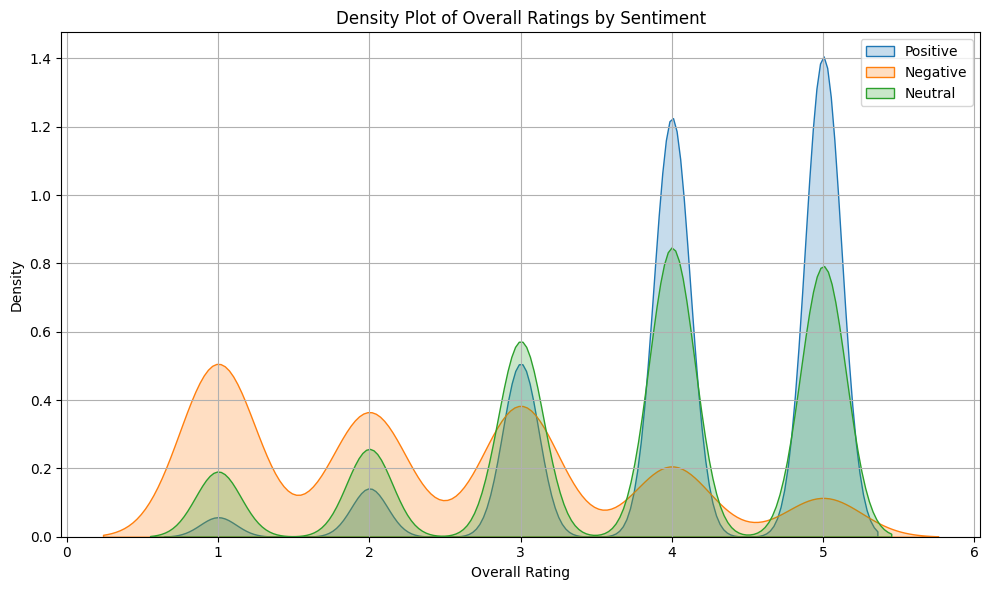

Supervised data saved as 'supervised_employee_feedback.csv'
Model and vectorizer saved successfully.


In [2]:
# Required Libraries
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle

# 1. Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# 2. Clean the text in 'summary'
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove links
    text = re.sub(r"[^a-zA-Z\s]", '', text)     # Remove punctuation and digits
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra whitespace
    return text

df['cleaned_summary'] = df['summary'].apply(clean_text)

# 3. Sentiment Analysis with TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)

# 4. Convert 'overall-ratings' to numeric
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')

# 5. Plot Density Graph of Ratings by Sentiment
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Sentiment'] == 'Positive']['overall-ratings'].dropna(), label='Positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Negative']['overall-ratings'].dropna(), label='Negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Neutral']['overall-ratings'].dropna(), label='Neutral', fill=True)
plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

# 6. Save Supervised CSV
df[['Sno.', 'job-title', 'summary', 'cleaned_summary', 'Sentiment']].to_csv("supervised_employee_feedback.csv", index=False)
print("Supervised data saved as 'supervised_employee_feedback.csv'")

# 7. ML Model: Train Random Forest
X = df['cleaned_summary']
y = df['Sentiment']

# Vectorize text
vectorizer = TfidfVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Train model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 8. Save model and vectorizer with Pickle
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("Model and vectorizer saved successfully.")




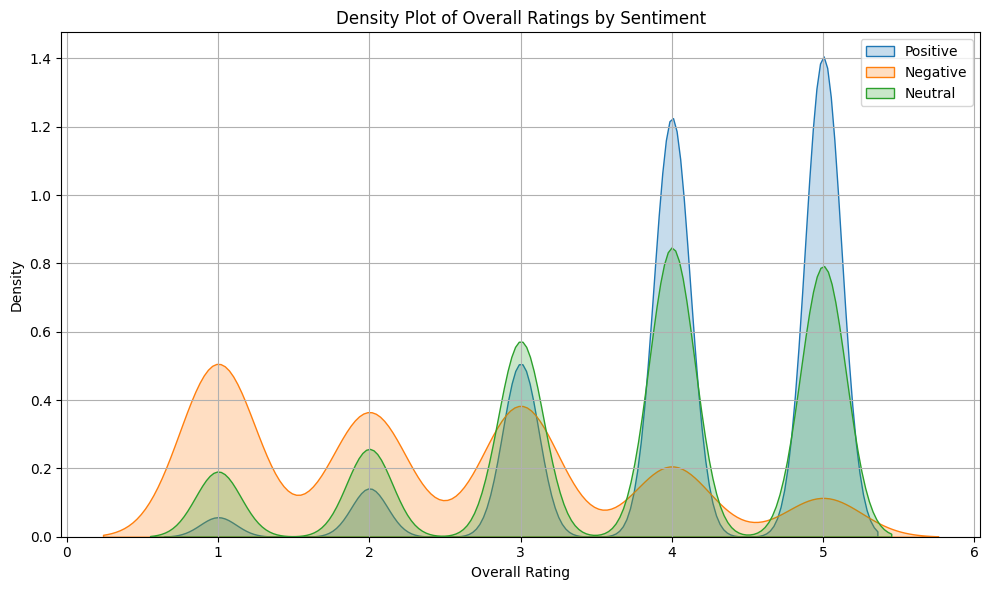

 Saved cleaned & labeled dataset as 'supervised_employee_feedback.csv'


In [4]:
#  Import Required Libraries
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle

#  Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# 3. Clean the text in 'summary'
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove hyperlinks
    text = re.sub(r"[^a-zA-Z\s]", '', text)     # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra whitespace
    return text

df['cleaned_summary'] = df['summary'].apply(clean_text)

#  Generate Sentiment Label using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)

#  Ensure 'overall-ratings' is numeric
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')

#  Plot Density Graph for Sentiment vs Ratings
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Sentiment'] == 'Positive']['overall-ratings'].dropna(), label='Positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Negative']['overall-ratings'].dropna(), label='Negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Neutral']['overall-ratings'].dropna(), label='Neutral', fill=True)
plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

#  Save Supervised Dataset with Only Cleaned Summary and Sentiment
df_supervised = df[['cleaned_summary', 'Sentiment']]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)
print(" Saved cleaned & labeled dataset as 'supervised_employee_feedback.csv'")

In [2]:

# Step 10: Vectorization
vectorizer = TfidfVectorizer(stop_words='english', max_features=5000)
X_vect = vectorizer.fit_transform(X)

# Step 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, stratify=y, random_state=42)

# Step 12: Train Classifier
model = RandomForestClassifier(n_estimators=200, random_state=42)
model.fit(X_train, y_train)

# Step 13: Save Model and Vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)




NameError: name 'X' is not defined

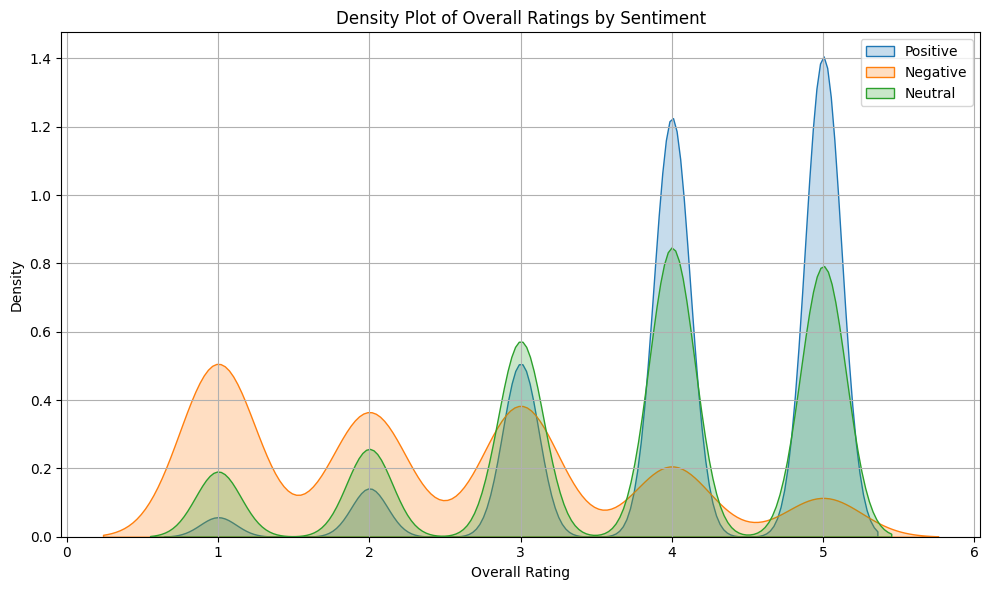

✅ Saved cleaned & labeled dataset as 'supervised_employee_feedback.csv'
✅ Model and vectorizer saved as 'sentiment_model.pkl' and 'vectorizer.pkl'


In [3]:
# 1. Import Required Libraries
import pandas as pd
import numpy as np
import re
from textblob import TextBlob
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pickle

# 2. Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# 3. Clean the text in 'summary'
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove hyperlinks
    text = re.sub(r"[^a-zA-Z\s]", '', text)     # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra whitespace
    return text

df['cleaned_summary'] = df['summary'].apply(clean_text)

# 4. Generate Sentiment Label using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)

# 5. Ensure 'overall-ratings' is numeric
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')

# 6. Plot Density Graph for Sentiment vs Ratings
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Sentiment'] == 'Positive']['overall-ratings'].dropna(), label='Positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Negative']['overall-ratings'].dropna(), label='Negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Neutral']['overall-ratings'].dropna(), label='Neutral', fill=True)
plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

# 7. Save Supervised Dataset with Only Cleaned Summary and Sentiment
df_supervised = df[['cleaned_summary', 'Sentiment']]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)
print("✅ Saved cleaned & labeled dataset as 'supervised_employee_feedback.csv'")

# 8. Prepare for Machine Learning
X = df_supervised['cleaned_summary']
y = df_supervised['Sentiment']

# Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Model Training: Random Forest
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# 9. Save Model and Vectorizer with Pickle
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

print("✅ Model and vectorizer saved as 'sentiment_model.pkl' and 'vectorizer.pkl'")


In [5]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Step 2: Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# Step 3: Merge and Clean Summary + Pros + Cons
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text) # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", '', text) # Remove punctuation and numbers
    text = re.sub(r"\s+", " ", text).strip() # Remove extra whitespace
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)

df["merged_feedback"] = df["summary"].fillna('') + " " + df["pros"].fillna('') + " " + df["cons"].fillna('')
df["cleaned_summary"] = df["merged_feedback"].apply(clean_text)

# Step 4: Sentiment Labeling using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["cleaned_summary"].apply(get_sentiment)

# Step 5: Ensure 'overall-ratings' is numeric
df["overall-ratings"] = pd.to_numeric(df["overall-ratings"], errors="coerce")
df = df.dropna(subset=["overall-ratings"])

# Step 6: Save Supervised Dataset
df_supervised = df[["cleaned_summary", "Sentiment", "overall-ratings"]]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)

# Step 7: Plot Sentiment Density Graph
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Sentiment'] == 'Positive']['overall-ratings'], label='Positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Negative']['overall-ratings'], label='Negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Neutral']['overall-ratings'], label='Neutral', fill=True)
plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

# Step 8: Prepare Data for Classification
X = df_supervised['cleaned_summary']
y = df_supervised['Sentiment']

# Step 9: Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)

# Step 10: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Step 11: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 12: Evaluation
y_pred = model.predict(X_test)
print("✅ Accuracy Score:", accuracy_score(y_test, y_pred))
print("\n📋 Classification Report:\n", classification_report(y_test, y_pred))
print("\n📊 Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

# Step 13: Save Model and Vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Step 14: Test a Sample Input
sample_input = "Management is supportive but the workload is often overwhelming"
sample_cleaned = clean_text(sample_input)
sample_vect = vectorizer.transform([sample_cleaned])
prediction = model.predict(sample_vect)[0]
print("\n🧪 Sample Input Prediction:", prediction)

# Completion message
print("\n✔️ Project completed successfully!")
print("Saved Files:")
print("- supervised_employee_feedback.csv")
print("- sentiment_model.pkl")
print("- vectorizer.pkl")
print("- sentiment_density_plot.png")


[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Wadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


KeyError: 'pros'

[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Wadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


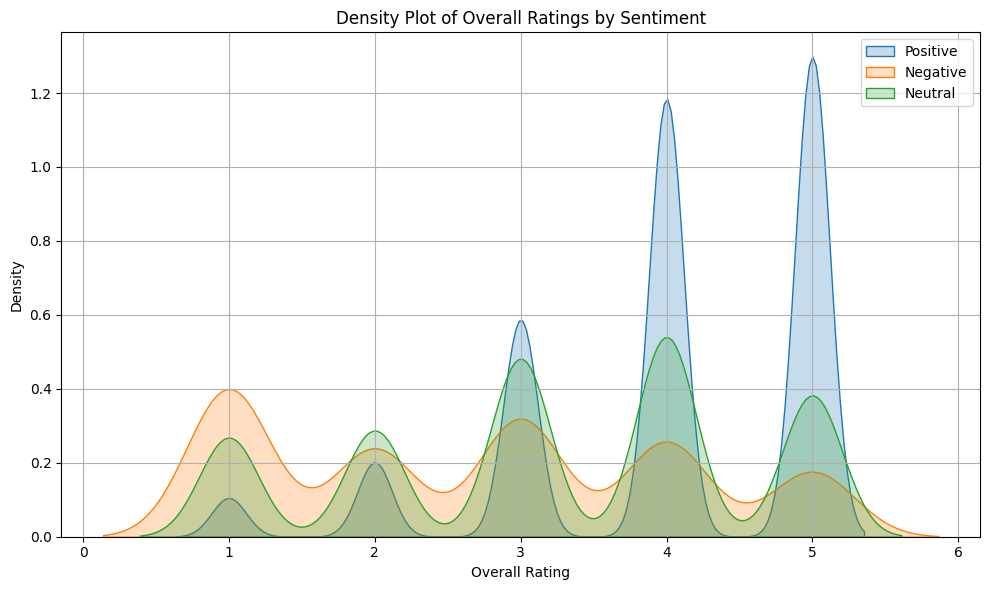

Classification Report:

              precision    recall  f1-score   support

    Negative       0.94      0.09      0.16       552
     Neutral       0.69      0.11      0.18      2074
    Positive       0.82      1.00      0.90     10502

    accuracy                           0.82     13128
   macro avg       0.82      0.40      0.41     13128
weighted avg       0.80      0.82      0.75     13128


Confusion Matrix:
[[   47    48   457]
 [    2   218  1854]
 [    1    51 10450]]

📝 Sample Input: The management is supportive but workload is overwhelming sometimes
🔍 Predicted Sentiment: Positive


In [7]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import re
import string

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Step 2: Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# Step 3: Combine 'summary' and 'pros&cons' into a single feedback field
df["merged_feedback"] = df["summary"].fillna('') + " " + df["pros&cons"].fillna('')

# Step 4: Text Cleaning
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove hyperlinks
    text = re.sub(r"[^a-zA-Z\s]", '', text)     # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra spaces
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)

df["cleaned_summary"] = df["merged_feedback"].apply(clean_text)

# Step 5: Sentiment Labeling using TextBlob
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity > 0.1:
        return "Positive"
    elif polarity < -0.1:
        return "Negative"
    else:
        return "Neutral"

df["Sentiment"] = df["cleaned_summary"].apply(get_sentiment)

# Step 6: Clean Ratings
df["overall-ratings"] = pd.to_numeric(df["overall-ratings"], errors="coerce")
df = df.dropna(subset=["overall-ratings"])

# Step 7: Save Supervised Dataset
df_supervised = df[["cleaned_summary", "Sentiment", "overall-ratings"]]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)

# Step 8: Sentiment Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df["Sentiment"] == "Positive"]["overall-ratings"], label="Positive", fill=True)
sns.kdeplot(df[df["Sentiment"] == "Negative"]["overall-ratings"], label="Negative", fill=True)
sns.kdeplot(df[df["Sentiment"] == "Neutral"]["overall-ratings"], label="Neutral", fill=True)
plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

# Step 9: Prepare Data for Classification
X = df_supervised["cleaned_summary"]
y = df_supervised["Sentiment"]

# Step 10: Vectorization
vectorizer = TfidfVectorizer(stop_words='english')
X_vect = vectorizer.fit_transform(X)

# Step 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42)

# Step 12: Train Random Forest Classifier
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 13: Model Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Step 14: Save Model and Vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Step 15: Predict a New Input
sample_text = "I hate working here "
sample_cleaned = clean_text(sample_text)
sample_vect = vectorizer.transform([sample_cleaned])
sample_prediction = model.predict(sample_vect)

print(f"\n📝 Sample Input: {sample_text}")
print(f"🔍 Predicted Sentiment: {sample_prediction[0]}")

In [8]:
sample_text = "I hate working here "
sample_cleaned = clean_text(sample_text)
sample_vect = vectorizer.transform([sample_cleaned])
sample_prediction = model.predict(sample_vect)

print(f"\n📝 Sample Input: {sample_text}")
print(f"🔍 Predicted Sentiment: {sample_prediction[0]}")


📝 Sample Input: I hate working here 
🔍 Predicted Sentiment: Neutral


In [9]:
# Step 9: Prepare Data for Classification
X = df_supervised['cleaned_summary']
y = df_supervised['Sentiment']

# Step 10: Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_vect = vectorizer.fit_transform(X)

# Step 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

# Step 12: Train Classifier with Class Weight Balancing
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Step 13: Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Step 14: Save Model and Vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Step 15: Test Sample Input
sample_text = "The management is supportive but workload is overwhelming sometimes"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")

Classification Report:

              precision    recall  f1-score   support

    Negative       0.92      0.13      0.22       518
     Neutral       0.70      0.19      0.29      2127
    Positive       0.83      0.99      0.91     10483

    accuracy                           0.83     13128
   macro avg       0.82      0.43      0.47     13128
weighted avg       0.81      0.83      0.78     13128


📝 Sample Input: The management is supportive but workload is overwhelming sometimes
📌 Predicted Sentiment: Positive


In [10]:
sample_text = "i hate this office"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")


📝 Sample Input: i hate this office
📌 Predicted Sentiment: Neutral


[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Wadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


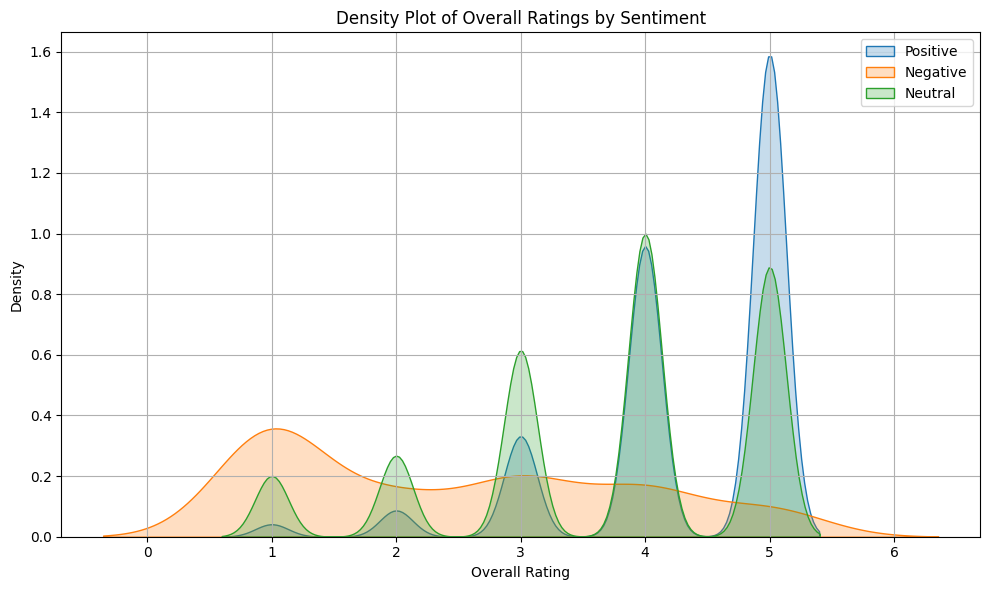

Classification Report:

              precision    recall  f1-score   support

    Negative       1.00      0.02      0.03        58
     Neutral       0.89      0.98      0.93     10482
    Positive       0.84      0.52      0.64      2588

    accuracy                           0.88     13128
   macro avg       0.91      0.50      0.53     13128
weighted avg       0.88      0.88      0.87     13128


📝 Sample Input: i hate this office
📌 Predicted Sentiment: Neutral


In [11]:
# Step 1: Import Required Libraries
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

# Step 2: Load Dataset
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# Step 3: Data Cleaning Function
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)  # Remove URLs
    text = re.sub(r"[^a-zA-Z\s]", '', text)     # Remove punctuation/numbers
    text = re.sub(r"\s+", " ", text).strip()    # Remove extra spaces
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)

# Step 4: Merge & Clean Summary + Pros & Cons
df["merged_feedback"] = df["summary"].fillna('') + " " + df["pros&cons"].fillna('')
df["cleaned_summary"] = df["merged_feedback"].apply(clean_text)

# Step 5: Custom Sentiment Labeling with New Thresholds
def get_sentiment(text):
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.5:
        return "Positive"
    elif polarity <= -0.5:
        return "Negative"
    else:
        return "Neutral"

df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)

# Step 6: Ensure 'overall-ratings' is numeric
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')
df = df.dropna(subset=['overall-ratings'])

# Step 7: Save Supervised Dataset
df_supervised = df[['cleaned_summary', 'Sentiment', 'overall-ratings']]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)

# Step 8: Sentiment Density Plot
plt.figure(figsize=(10, 6))
sns.kdeplot(df[df['Sentiment'] == 'Positive']['overall-ratings'], label='Positive', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Negative']['overall-ratings'], label='Negative', fill=True)
sns.kdeplot(df[df['Sentiment'] == 'Neutral']['overall-ratings'], label='Neutral', fill=True)

plt.title("Density Plot of Overall Ratings by Sentiment")
plt.xlabel("Overall Rating")
plt.ylabel("Density")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("sentiment_density_plot.png")
plt.show()

# Step 9: Prepare Data for Classification
X = df_supervised['cleaned_summary']
y = df_supervised['Sentiment']

# Step 10: Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_vect = vectorizer.fit_transform(X)

# Step 11: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

# Step 12: Train Classifier with Class Weight Balancing
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Step 13: Evaluation
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))

# Step 14: Save Model and Vectorizer
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)

# Step 15: Test Sample Input
sample_text = "i hate this office"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")


In [14]:
def get_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['hate', 'toxic', 'worst', 'awful', 'horrible']):
        return "Negative"
    if any(word in text for word in ['love', 'excellent', 'great', 'fantastic', 'amazing']):
        return "Positive"
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.5:
        return "Positive"
    elif polarity <= -0.5:
        return "Negative"
    else:
        return "Neutral"


In [15]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Wadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [16]:
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

In [17]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", " ", text).strip()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)


In [18]:
import pandas as pd
import numpy as np
import re
import string
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import pickle

import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to C:\Users\Khushi
[nltk_data]     Wadhawan\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [19]:
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')
df.head()


,Sno.,job-title,summary,pros&cons,overall-ratings,"sentiment-neg,z,pos"
0,1,Current Employee - Program Manager II,My Stint at Amazon,* Learning Opportunities * Growth Opportunitie...,4,NaN
1,2,Current Employee - Anonymous Employee,Software Developer Intern,Nice work culture. Projects have scale of real...,4,NaN
2,3,Current Employee - Anonymous Employee,QAE-II,Good Work culture.. Flexi timings... ---------...,4,NaN
3,4,Former Employee - Specialist,Part Time Specialist,NaN,4,NaN
4,5,Current Employee - Senior Technical Writer,A great place for Technical Writers/Programmin...,- A growing team - as Amazon adds new web serv...,5,NaN


In [20]:
def clean_text(text):
    if pd.isnull(text):
        return ""
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", '', text)
    text = re.sub(r"[^a-zA-Z\s]", '', text)
    text = re.sub(r"\s+", " ", text).strip()
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered = [word for word in words if word not in stop_words]
    return " ".join(filtered)


In [21]:
df["merged_feedback"] = df["summary"].fillna('') + " " + df["pros&cons"].fillna('')
df["cleaned_summary"] = df["merged_feedback"].apply(clean_text)
df[["merged_feedback", "cleaned_summary"]].head()


,merged_feedback,cleaned_summary
0,My Stint at Amazon * Learning Opportunities * ...,stint amazon learning opportunities growth opp...
1,Software Developer Intern Nice work culture. P...,software developer intern nice work culture pr...
2,QAE-II Good Work culture.. Flexi timings... --...,qaeii good work culture flexi timings
3,Part Time Specialist,part time specialist
4,A great place for Technical Writers/Programmin...,great place technical writersprogramming write...


In [22]:
def get_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['hate', 'toxic', 'worst', 'awful', 'horrible', 'fired', 'bully']):
        return "Negative"
    if any(word in text for word in ['love', 'excellent', 'great', 'fantastic', 'amazing', 'supportive']):
        return "Positive"
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.5:
        return "Positive"
    elif polarity <= -0.5:
        return "Negative"
    else:
        return "Neutral"


In [23]:
df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)
df[['cleaned_summary', 'Sentiment']].head()


,cleaned_summary,Sentiment
0,stint amazon learning opportunities growth opp...,Positive
1,software developer intern nice work culture pr...,Neutral
2,qaeii good work culture flexi timings,Positive
3,part time specialist,Neutral
4,great place technical writersprogramming write...,Positive


In [24]:
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')
df = df.dropna(subset=['overall-ratings'])


In [25]:
df_supervised = df[['cleaned_summary', 'Sentiment', 'overall-ratings']]

df_balanced = df_supervised.groupby('Sentiment').apply(
    lambda x: x.sample(n=1000, random_state=42, replace=True)
).reset_index(drop=True)

df_balanced['Sentiment'].value_counts()


C:\Users\Khushi Wadhawan\AppData\Local\Temp\ipykernel_58052\561057233.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_balanced = df_supervised.groupby('Sentiment').apply(


Sentiment
Negative    1000
Neutral     1000
Positive    1000
Name: count, dtype: int64

In [53]:
df_balanced['Sentiment'].value_counts()

Sentiment
Negative    1000
Neutral     1000
Positive    1000
Name: count, dtype: int64

In [26]:
X = df_balanced['cleaned_summary']
y = df_balanced['Sentiment']


In [27]:
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_vect = vectorizer.fit_transform(X)
X_vect.shape


(3000, 10000)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    X_vect, y, test_size=0.2, random_state=42, stratify=y
)


In [29]:
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(class_weight='balanced', n_estimators=200,
                       random_state=42)

In [30]:
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88       200
     Neutral       0.80      0.90      0.85       200
    Positive       0.87      0.82      0.85       200

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [31]:
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.91      0.85      0.88       200
     Neutral       0.80      0.90      0.85       200
    Positive       0.87      0.82      0.85       200

    accuracy                           0.86       600
   macro avg       0.86      0.86      0.86       600
weighted avg       0.86      0.86      0.86       600



In [32]:
with open("sentiment_model.pkl", "wb") as f:
    pickle.dump(model, f)

with open("vectorizer.pkl", "wb") as f:
    pickle.dump(vectorizer, f)


In [33]:
sample_text = "i hate this office"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")



📝 Sample Input: i hate this office
📌 Cleaned Text: hate office
📌 Predicted Sentiment: Negative
📌 TextBlob Polarity: -0.8


In [34]:
sample_text = "i love this office"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: i love this office
📌 Cleaned Text: love office
📌 Predicted Sentiment: Positive
📌 TextBlob Polarity: 0.5


In [36]:
sample_text = "i dont like the workload but i like the work culture"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: i dont like the workload but i like the work culture
📌 Cleaned Text: dont like workload like work culture
📌 Predicted Sentiment: Neutral
📌 TextBlob Polarity: 0.0


In [37]:
sample_text = "i like the building"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: i like the building
📌 Cleaned Text: like building
📌 Predicted Sentiment: Neutral
📌 TextBlob Polarity: 0.0


In [38]:
sample_text = "i really like the office"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: i really like the office
📌 Cleaned Text: really like office
📌 Predicted Sentiment: Neutral
📌 TextBlob Polarity: 0.2


In [40]:
sample_text = "i think office is amazing"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: i think office is amazing
📌 Cleaned Text: think office amazing
📌 Predicted Sentiment: Positive
📌 TextBlob Polarity: 0.6000000000000001


In [41]:
def get_sentiment(text):
    text = text.lower()
    if any(word in text for word in ['hate', 'toxic', 'worst', 'awful', 'horrible', 'fired', 'bully']):
        return "Negative"
    if any(word in text for word in ['love', 'excellent', 'great', 'fantastic', 'amazing', 'supportive', 'like']):
        return "Positive"
    
    polarity = TextBlob(text).sentiment.polarity
    
    if polarity >= 0.2:
        return "Positive"
    elif polarity <= -0.2:
        return "Negative"
    else:
        return "Neutral"


In [42]:
df['Sentiment'] = df['cleaned_summary'].apply(get_sentiment)
df[['cleaned_summary', 'Sentiment']].head()


,cleaned_summary,Sentiment
0,stint amazon learning opportunities growth opp...,Positive
1,software developer intern nice work culture pr...,Positive
2,qaeii good work culture flexi timings,Positive
3,part time specialist,Neutral
4,great place technical writersprogramming write...,Positive


In [43]:
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')
df = df.dropna(subset=['overall-ratings'])


In [44]:
sample_text = "there is too much work load"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")


📝 Sample Input: there is too much work load
📌 Cleaned Text: much work load
📌 Predicted Sentiment: Neutral
📌 TextBlob Polarity: 0.2


In [48]:
# Step 3: Sentiment Labeling Function
def get_sentiment(text):
    text = text.lower()

    # Rule-based override for common complaints
    negative_keywords = [
        'hate', 'toxic', 'worst', 'awful', 'horrible', 'fired', 'bully',
        'too much work', 'overload', 'workload', 'underpaid', 'stress',
        'burnout', 'micromanaged', 'no growth', 'long hours'
    ]
    if any(phrase in text for phrase in negative_keywords):
        return "Negative"

    # Rule-based override for common praises
    positive_keywords = ['love', 'excellent', 'great', 'fantastic', 'amazing', 'supportive', 'like']
    if any(phrase in text for phrase in positive_keywords):
        return "Positive"

    # Fallback to TextBlob
    polarity = TextBlob(text).sentiment.polarity
    if polarity >= 0.2:
        return "Positive"
    elif polarity <= -0.2:
        return "Negative"
    else:
        return "Neutral"


In [49]:
# Step 4: Load CSV
df = pd.read_csv(r"C:\Users\Khushi Wadhawan\Desktop\employee_feedbacks.csv", encoding='latin1')

# Step 5: Merge & Clean Text Columns
df["merged_feedback"] = df["summary"].fillna('') + " " + df["pros&cons"].fillna('')
df["cleaned_summary"] = df["merged_feedback"].apply(clean_text)

# Step 6: Generate Sentiment Labels
df['Sentiment'] = df['merged_feedback'].apply(get_sentiment)

# Step 7: Ensure numeric ratings
df['overall-ratings'] = pd.to_numeric(df['overall-ratings'], errors='coerce')
df = df.dropna(subset=['overall-ratings'])

# Step 8: Save Supervised Data
df_supervised = df[['cleaned_summary', 'Sentiment', 'overall-ratings']]
df_supervised.to_csv("supervised_employee_feedback.csv", index=False)


In [50]:
# Step 10: Prepare Data for Training
X = df_supervised['cleaned_summary']
y = df_supervised['Sentiment']

# Step 11: Vectorize Text
vectorizer = TfidfVectorizer(stop_words='english', max_features=10000)
X_vect = vectorizer.fit_transform(X)

# Step 12: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_vect, y, test_size=0.2, random_state=42, stratify=y)

# Step 13: Train Model
model = RandomForestClassifier(n_estimators=200, class_weight='balanced', random_state=42)
model.fit(X_train, y_train)

# Step 14: Evaluate
y_pred = model.predict(X_test)
print("Classification Report:\n")
print(classification_report(y_test, y_pred))


Classification Report:

              precision    recall  f1-score   support

    Negative       0.95      0.57      0.71      1835
     Neutral       0.73      0.42      0.53      2225
    Positive       0.82      0.97      0.89      9068

    accuracy                           0.82     13128
   macro avg       0.83      0.65      0.71     13128
weighted avg       0.82      0.82      0.80     13128



In [51]:
# Step 16: Sample Input Prediction
sample_text = "there is too much work load"
cleaned_sample = clean_text(sample_text)
sample_vect = vectorizer.transform([cleaned_sample])
predicted_sentiment = model.predict(sample_vect)[0]

print(f"\n📝 Sample Input: {sample_text}")
print(f"📌 Cleaned Text: {cleaned_sample}")
print(f"📌 Predicted Sentiment: {predicted_sentiment}")
print(f"📌 TextBlob Polarity: {TextBlob(sample_text).sentiment.polarity}")



📝 Sample Input: there is too much work load
📌 Cleaned Text: much work load
📌 Predicted Sentiment: Neutral
📌 TextBlob Polarity: 0.2


In [54]:
#1.recall prec, 2. smote, 3.w/o merging summary&pros and cons, 4. diff vectorization , 5.ui

In [55]:
#6. cross validation train split, 7. parameter tuning, 

In [56]:
#8. git!